In [1]:
!pip install --quiet google-cloud-bigquery

# Import libraries
from google.cloud import bigquery
from google.colab import auth

# Authenticate your Google account
auth.authenticate_user()

# Set up BigQuery client (use your GCP project ID)
project_id = 'akashapiplayground'  # Replace with your actual project ID
client = bigquery.Client(project=project_id)

In [2]:
# ICD9. 430. Subarachnoid hemorrage
# Filter those diagnoses where billing was for 430
query = """

  SELECT *
  FROM physionet-data.mimiciii_clinical.diagnoses_icd
  WHERE icd9_code  IN ('430')
  """

query_job = client.query(query)
diagnoses = query_job.to_dataframe()
arr_subject_id=[]
arr_hadm_id=[]
for row in range(0, len(diagnoses)):
  if(diagnoses.loc[row, 'ICD9_CODE'] in ['430']):
    arr_subject_id.append(diagnoses.loc[row, 'SUBJECT_ID'])
    arr_hadm_id.append(diagnoses.loc[row, 'HADM_ID'])

print(f"{len(arr_subject_id)=}")

len(arr_subject_id)=658


In [3]:
# Filter those notevents where subejct_id and hadm_id matches the one returned
# from diagnoses_icd query
query = """

  SELECT *
  FROM physionet-data.mimiciii_notes.noteevents
  """

query_job = client.query(query)
noteevents = query_job.to_dataframe()
df_noteevents_filtered = noteevents[noteevents['SUBJECT_ID'].isin(arr_subject_id) & noteevents['HADM_ID'].isin(arr_hadm_id)]
df_discharge_notes = df_noteevents_filtered[df_noteevents_filtered['CATEGORY'] == 'Discharge summary']
print(f"{len(df_discharge_notes)=}")
df_discharge_notes.to_csv('df_discharge_notes_430.csv', index=False)

len(df_discharge_notes)=697


#Using Spacy

In [4]:
!pip install -U pip setuptools wheel
!python -m spacy download en_core_web_md
!pip install spacy==3.7.5
!pip install scispacy
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 54.7 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 75.2.0
    Uninstalling setuptools-75.2.0:
      Successfully uninstalled setuptools-75.2.0
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 7.34.0 requires jedi>=0.16, which is not installed.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 51.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 74.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.2/920.2 kB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 136.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 165.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: blis
    Found existing installation: blis 1.3.0
    Uninstalling blis-1.3.0:
      Successfu

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import re
from gensim.models import word2vec

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
noteevents_df = pd.read_csv('/content/df_discharge_notes_430.csv')
noteevents_df.info()
noteevents_df.iloc[0]['TEXT']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 697 entries, 0 to 696
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ROW_ID       697 non-null    int64  
 1   SUBJECT_ID   697 non-null    int64  
 2   HADM_ID      697 non-null    int64  
 3   CHARTDATE    697 non-null    object 
 4   CHARTTIME    0 non-null      float64
 5   STORETIME    0 non-null      float64
 6   CATEGORY     697 non-null    object 
 7   DESCRIPTION  697 non-null    object 
 8   CGID         0 non-null      float64
 9   ISERROR      0 non-null      float64
 10  TEXT         697 non-null    object 
dtypes: float64(4), int64(3), object(4)
memory usage: 60.0+ KB


'Name:  [**Known lastname 11012**],[**Known firstname 4176**]                   Unit No:   [**Numeric Identifier 11013**]\n\nAdmission Date:  [**2162-2-25**]              Discharge Date:   [**2162-4-12**]\n\nDate of Birth:  [**2102-1-30**]             Sex:   F\n\nService: NEUROSURGERY\n\nAllergies:\nCodeine / Acetaminophen\n\nAttending:[**First Name3 (LF) 10598**]\nAddendum:\npatient has remained neurologically unchanged. She was having\nsome bleeding from her trach. General surgery did a bronchoscopy\non her which did not show anything, since then she continues to\nhave some pink tinged sputum, but no frank blood as before. Her\ncondition as otherwise remained stable. she will followup with\n[**First Name8 (NamePattern2) **] [**Name8 (MD) 365**] MD in one month.\n\nChief Complaint:\nSubarachnoid hermorrhage\n\nDischarge Disposition:\nExtended Care\n\nFacility:\n[**Hospital6 2876**] - [**Location (un) 3542**]\n\n                             [**Name6 (MD) **] [**Last Name (NamePattern4)

In [13]:
#Visualize entities using Spicy
import spacy
from spacy import displacy
nlp_spacy = spacy.load('en_core_web_md')
doc = []
# For viz, only read the first 2 notes
for i in range(0,min(2,len(noteevents_df))):
  doc.append(nlp_spacy(noteevents_df.iloc[i]['TEXT']))
for i in range(0, len(doc)):
  displacy.render(doc[i], style="ent", jupyter=True)
  print("******************************************")

/usr/local/lib/python3.11/dist-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_md' (3.8.0) was trained with spaCy v3.8.0 and may not be 100% compatible with the current version (3.7.5). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


******************************************


******************************************


In [ ]:
#Visualize entities using SpiSpicy
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.5.4/en_ner_bc5cdr_md-0.5.4.tar.gz
import en_ner_bc5cdr_md
from spacy import displacy

In [65]:
nlp_spispacy = en_ner_bc5cdr_md.load()

In [66]:
doc = []
for i in range(0,min(2,len(noteevents_df))):
  doc.append(nlp_spispacy(noteevents_df.iloc[i]['TEXT']))
for i in range(0, len(doc)):
  displacy.render(doc[i], style="ent", jupyter=True)
  print("******************************************")

******************************************


******************************************


In [15]:
def tsne_plot(model,words, preTrained=False):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in words:
      if preTrained:
          tokens.append(model[word])
      else:
          tokens.append(model.wv[word])
      labels.append(word)

    tokens = np.array(tokens)
    tsne_model = TSNE(perplexity=30, early_exaggeration=12, n_components=2, init='pca', n_iter=1000, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(16, 16))
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [28]:
# Spacy Word2Vec
spacy_corpus=[]
for row in range(0, len(noteevents_df)):
  str_tokens=[]
  tokens= nlp_spacy(noteevents_df.iloc[row]['TEXT']).ents
  for i in range(0, len(tokens)):
    str_tokens.append(tokens[i].text)
  spacy_corpus.append(list(str_tokens))

print(f"{spacy_corpus[0]=}")

from gensim.models import Word2Vec
model_spacy = Word2Vec(spacy_corpus, min_count=5)

spacy_corpus[0]=['11012**],[**Known', '4176', '11013', '2162', '2162', '2102', 'F\n\nService', 'LF', '10598', 'NamePattern2', 'MD', '365', 'MD', 'one month', 'Subarachnoid', 'Extended Care\n\nFacility', 'un', '3542', 'MD', 'MD', '10600', '4']


In [34]:
#print(f"{model_spacy.wv['Numbness']=}")
model_spacy.wv.similar_by_word('Tylenol')

[('24 hours', 0.9921581745147705),
 ('325mg', 0.9832966923713684),
 ('1 week', 0.974217414855957),
 ('Angiogram with Embolization and/or Stent', 0.9700952768325806),
 ('Clopidogrel', 0.9624456167221069),
 ('half', 0.9304239153862),
 ('daily', 0.9185819625854492),
 ('Numbness', 0.9112173914909363),
 ('4 weeks', 0.9100661277770996),
 ('10 minutes', 0.9071342349052429)]

In [30]:
# SpiSpacy Word2Vec
spispacy_corpus=[]
for row in range(0, len(noteevents_df)):
  str_tokens=[]
  tokens= nlp_spispacy(noteevents_df.iloc[row]['TEXT']).ents
  for i in range(0, len(tokens)):
    str_tokens.append(tokens[i].text)
  spispacy_corpus.append(list(str_tokens))

print(f"{spispacy_corpus[0]=}")

from gensim.models import Word2Vec
model_spispacy = Word2Vec(spispacy_corpus, min_count=5)

spispacy_corpus[0]=['Codeine', 'Acetaminophen', 'bleeding', 'Subarachnoid hermorrhage']


In [33]:
#print(f"{model_spispacy.wv['Numbness']=}")
model_spispacy.wv.similar_by_word('Tylenol')

[('pain', 0.9858289361000061),
 ('groin', 0.9763584733009338),
 ('loss of vision', 0.9763126373291016),
 ('Numbness', 0.9738684296607971),
 ('coldness', 0.9657901525497437),
 ('bleeding', 0.9600784778594971),
 ('Clopidogrel', 0.9528343677520752),
 ('Tablet(s', 0.949036717414856),
 ('Aspirin', 0.9489686489105225),
 ('arachnoid hemorrhage', 0.9320459365844727)]

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


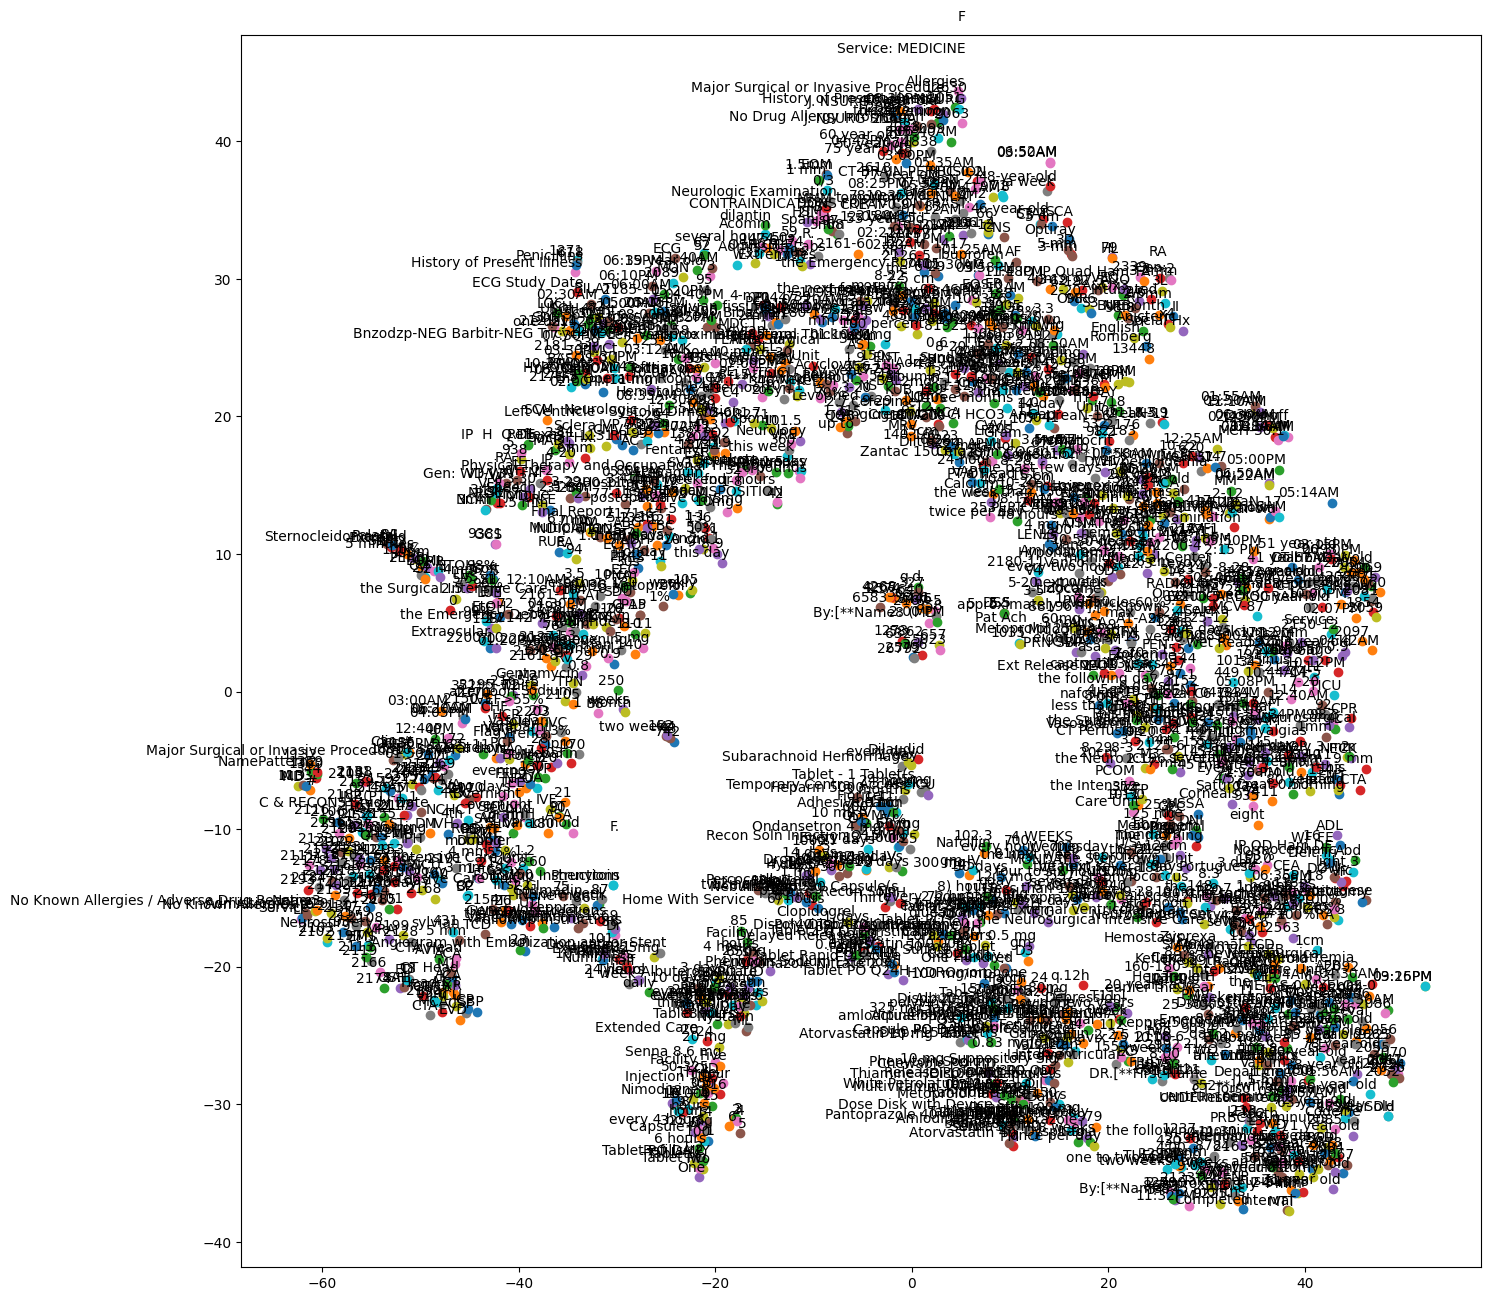

In [36]:
#Spacy tSNE
vocabs_spacy = model_spacy.wv.key_to_index.keys()
new_v_spacy = np.array(list(vocabs_spacy))
tsne_plot(model_spacy,new_v_spacy)

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


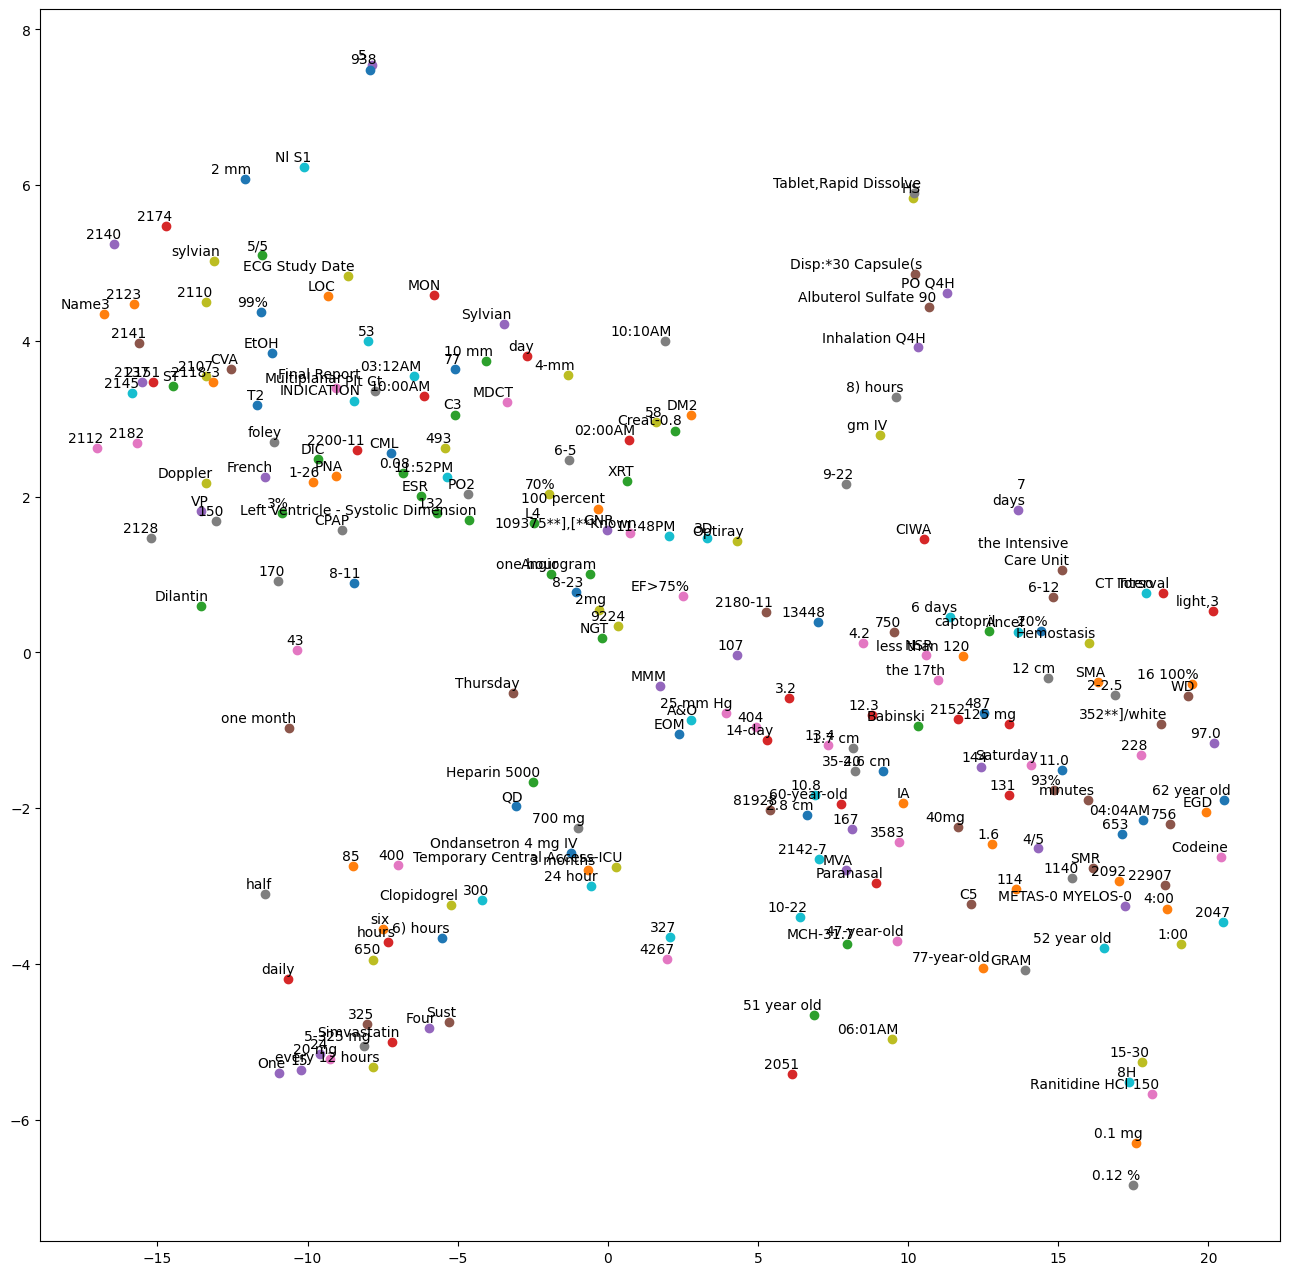

In [39]:
import random
new_v_spacy_sampled = np.array(random.sample(list(vocabs_spacy), int(len(vocabs_spacy) * 0.10)))
tsne_plot(model_spacy,new_v_spacy_sampled)

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


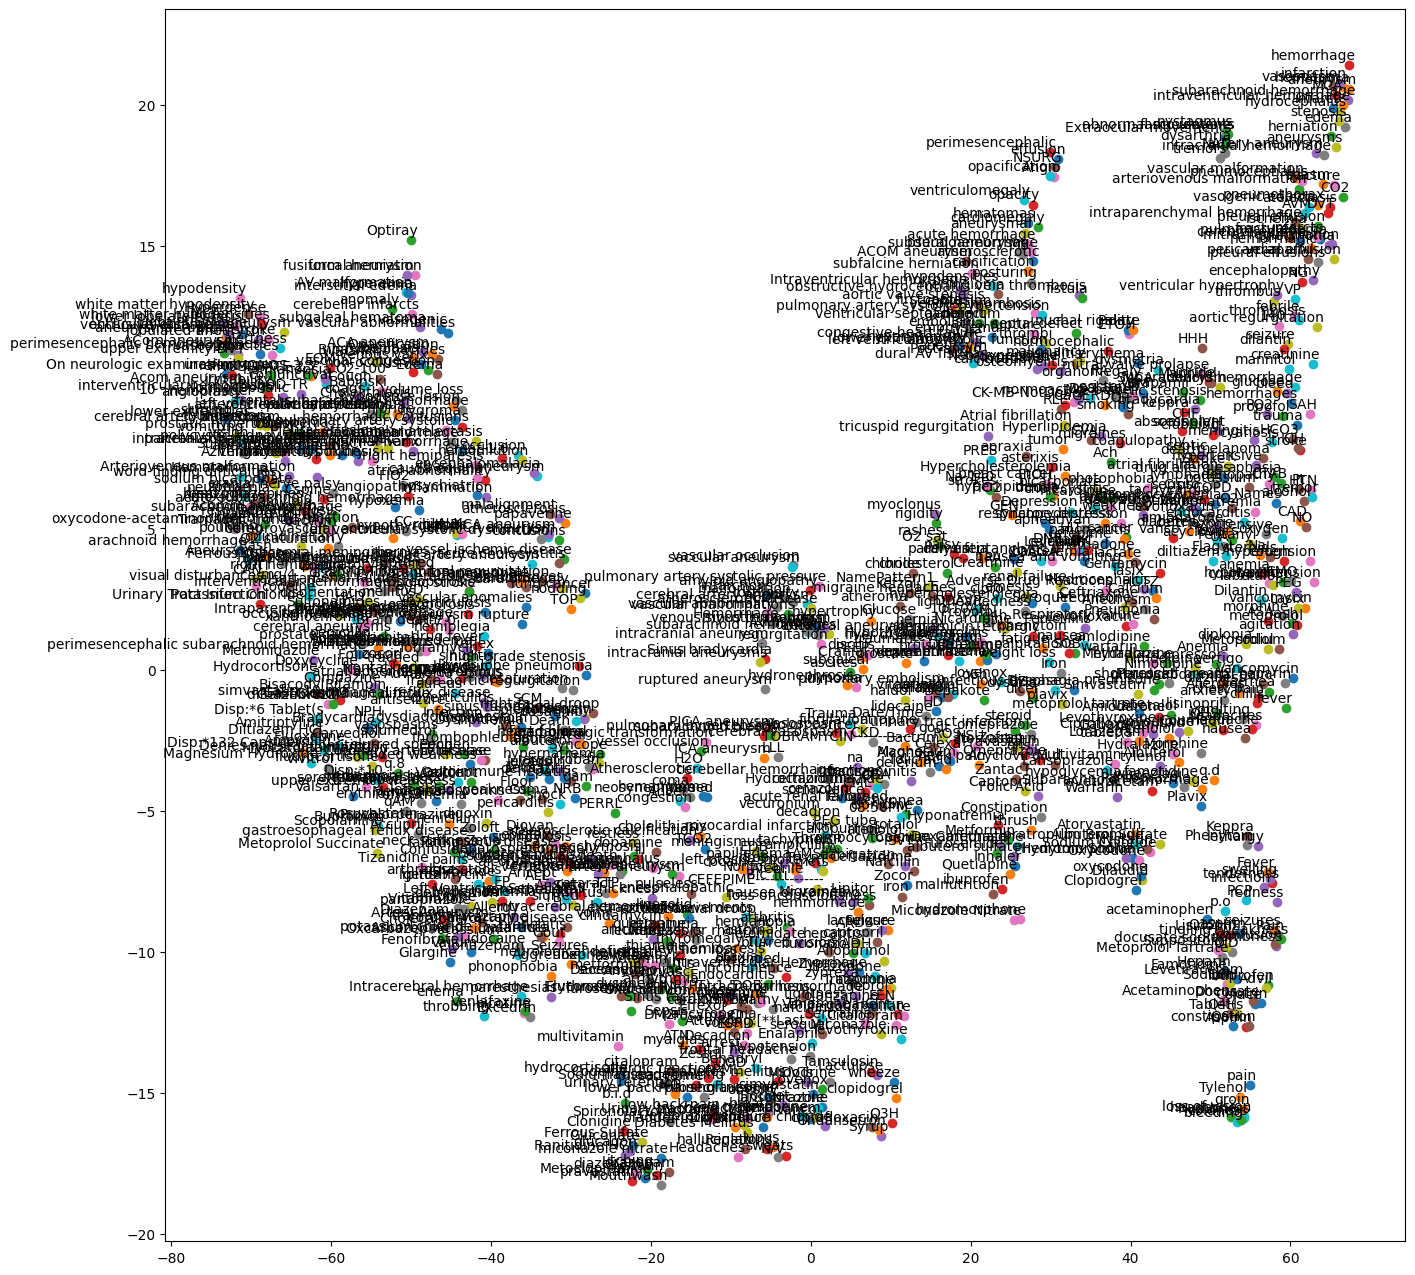

In [37]:
#SpiSpacy tSNE
vocabs_spispacy = model_spispacy.wv.key_to_index.keys()
new_v_spispacy = np.array(list(vocabs_spispacy))
tsne_plot(model_spispacy,new_v_spispacy)

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


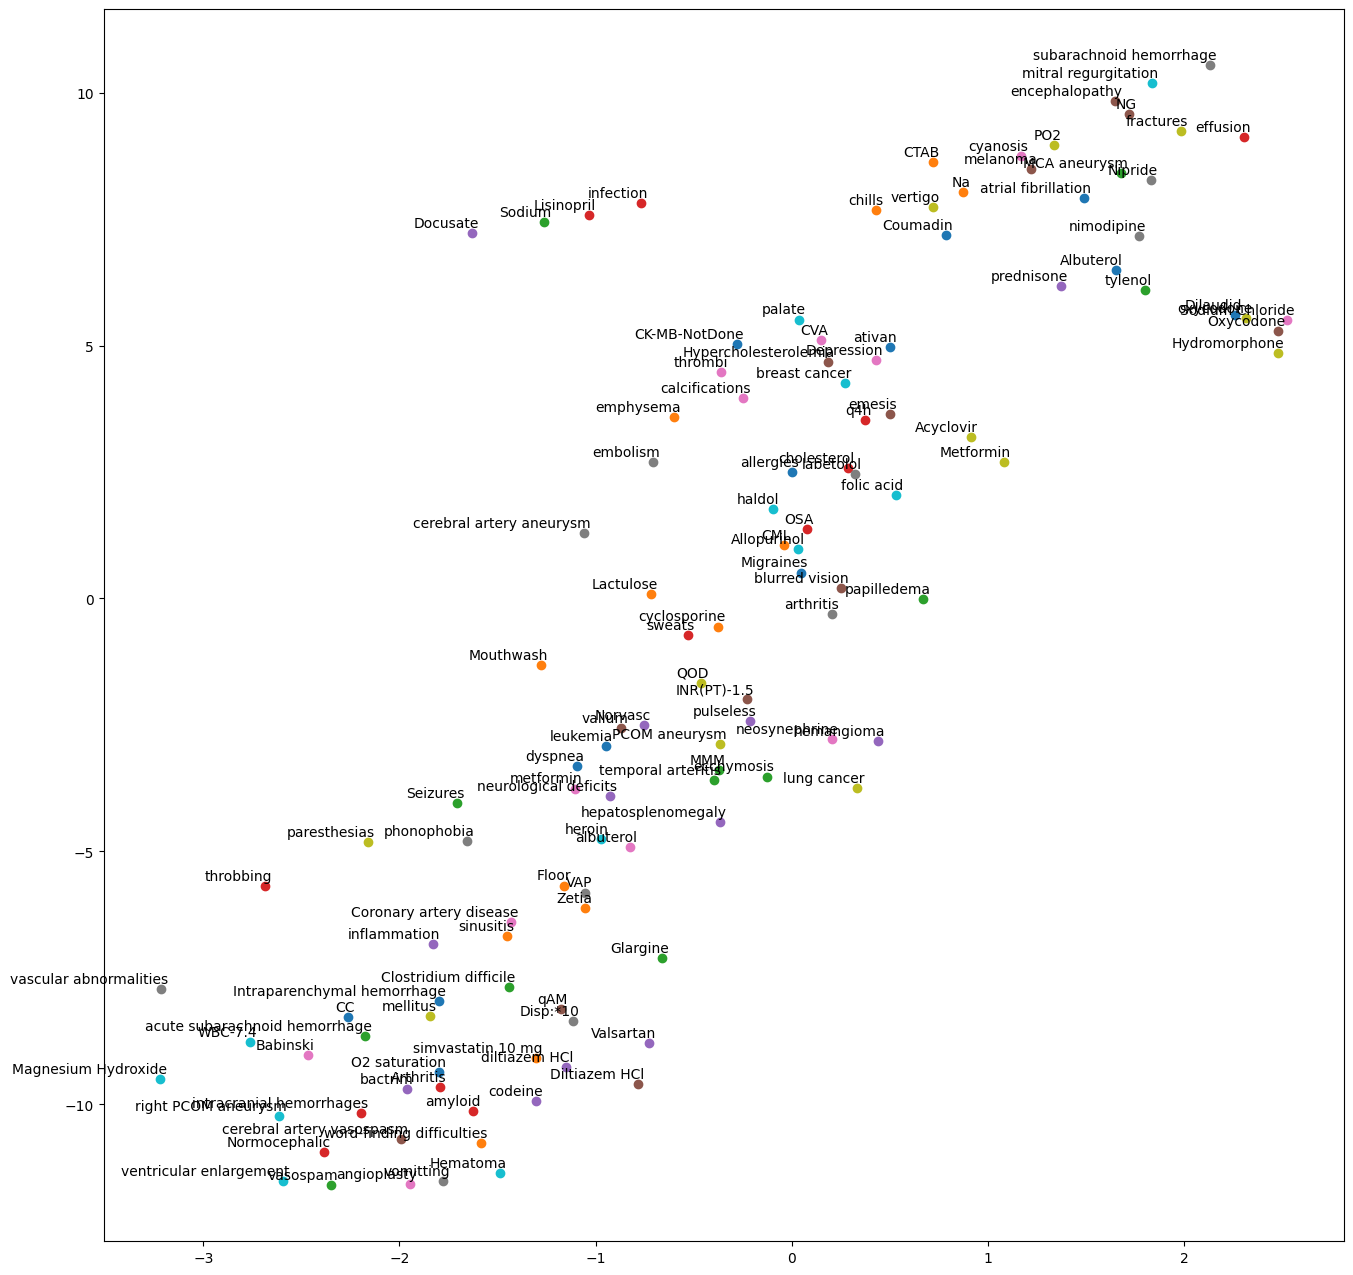

In [38]:
#SpiSpacy tSNE with 10% data for visual clarity
import random
new_v_spispacy_sampled = np.array(random.sample(list(vocabs_spispacy), int(len(vocabs_spispacy) * 0.10)))
tsne_plot(model_spispacy,new_v_spispacy_sampled)

#Using medSpacy

In [42]:
!pip install medspacy
import medspacy

ValueError: [E007] 'medspacy_pyrush' already exists in pipeline. Existing names: ['tok2vec', 'tagger', 'attribute_ruler', 'lemmatizer', 'parser', 'ner', 'medspacy_pyrush', 'medspacy_target_matcher', 'medspacy_context']

In [48]:
from medspacy.ner import TargetRule

In [71]:
nlp_medspacy = medspacy.load()
# Add rules for target concept extraction
target_matcher = nlp_medspacy.get_pipe("medspacy_target_matcher")
target_rules = [
    TargetRule("headaches", "PROBLEM"), TargetRule("pruritis", "PROBLEM"),
    TargetRule("arthitis", "PROBLEM"), TargetRule("seizure", "PROBLEM"),
    TargetRule("neck pain", "PROBLEM"), TargetRule("pain", "PROBLEM"),
    TargetRule("constipation", "PROBLEM"), TargetRule("hemorrhage", "PROBLEM"),
    TargetRule("numbness", "PROBLEM"), TargetRule("aneurysm", "PROBLEM"),
    TargetRule("docusate sodium", "MEDICATION"),
    TargetRule("nimodipine", "MEDICATION"),
    TargetRule("aspirin", "MEDICATION"),
    TargetRule("hydromorphone", "MEDICATION"),
    TargetRule("tylenol", "MEDICATION")
]
target_matcher.add(target_rules)

In [72]:
# Entity Visualization using Medspacy
doc = []
for i in range(0,min(2,len(noteevents_df))):
  doc.append(nlp_medspacy(noteevents_df.iloc[i]['TEXT']))
for i in range(0, len(doc)):
  displacy.render(doc[i], style="ent", jupyter=True)
  print("******************************************")

******************************************


******************************************


In [73]:
medspacy_corpus=[]
for row in range(0, len(noteevents_df)):
  str_tokens=[]
  tokens= nlp_medspacy(noteevents_df.iloc[row]['TEXT']).ents
  for i in range(0, len(tokens)):
    str_tokens.append(tokens[i].text)
  medspacy_corpus.append(list(str_tokens))

print(f"{medspacy_corpus[0]=}")

from gensim.models import Word2Vec
model_medspacy = Word2Vec(medspacy_corpus, min_count=5)

medspacy_corpus[0]=[]


In [74]:
model_medspacy.wv.similar_by_word('Tylenol')

[('HEMORRHAGE', 0.99864262342453),
 ('tylenol', 0.9986121654510498),
 ('pain', 0.9984748363494873),
 ('SEIZURE', 0.9984593987464905),
 ('ANEURYSM', 0.9984049797058105),
 ('Aneurysm', 0.9983913898468018),
 ('Hydromorphone', 0.9983870387077332),
 ('Aspirin', 0.9983742237091064),
 ('Nimodipine', 0.9983552694320679),
 ('nimodipine', 0.9983541369438171)]

In [75]:
def tsne_plot_medspacy(model,words, preTrained=False):
    "Creates and TSNE model and plots it"
    labels = []
    tokens = []

    for word in words:
      if preTrained:
          tokens.append(model[word])
      else:
          tokens.append(model.wv[word])
      labels.append(word)

    tokens = np.array(tokens)
    tsne_model = TSNE(perplexity=30, early_exaggeration=12, n_components=2, init='pca', n_iter=1000, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])

    plt.figure(figsize=(16, 16))
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

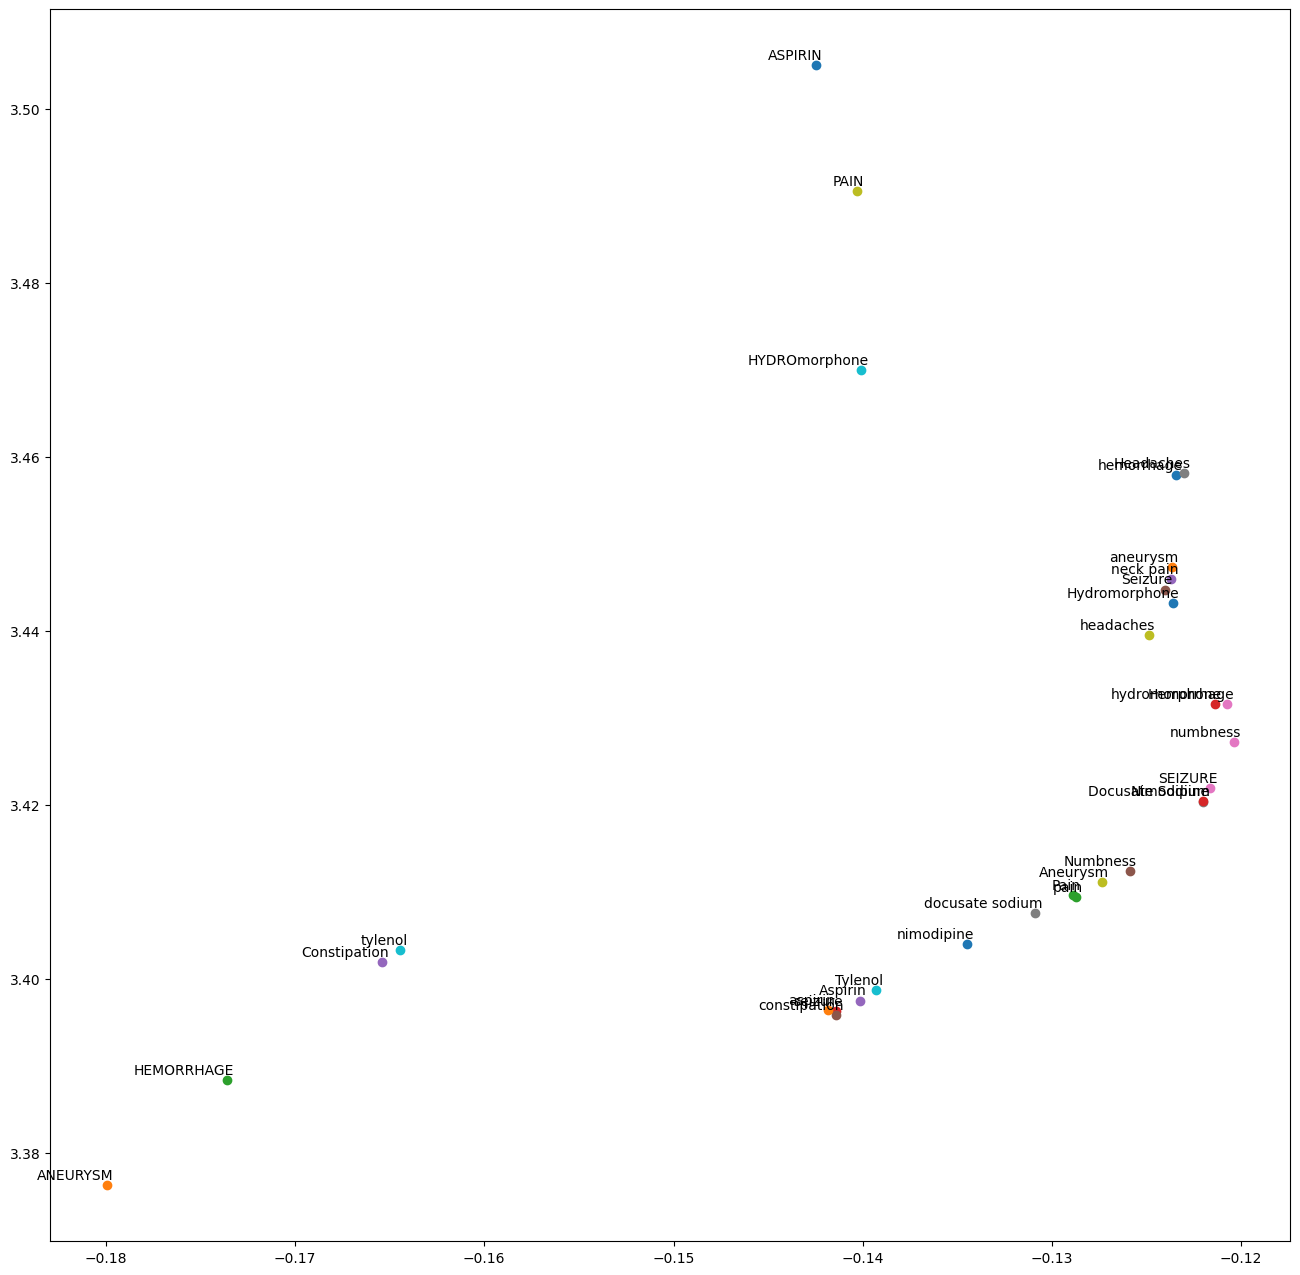

In [76]:
#MedSpacy tSNE
vocabs_medspacy = model_medspacy.wv.key_to_index.keys()
new_v_medspacy = np.array(list(vocabs_medspacy))
tsne_plot_medspacy(model_medspacy,new_v_medspacy)